In [19]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
import scipy.optimize as sco
import scipy.interpolate as sci
from tqdm import  tqdm#看进度条
import itertools

In [20]:
df = pd.read_excel('data.xlsx',index_col=0)
hist_close = pd.pivot_table(df,index='index',columns='code',values='close')
returns = np.log(hist_close/hist_close.shift(1))#计算收益率
returns_clean = returns.dropna(axis=0)

In [21]:
returns_clean.head()

code,002230.XSHE,300595.XSHE,300692.XSHE,510630.XSHG,600809.XSHG
index,,,,,
2019-01-03,0.015541,0.012182,-0.030772,-0.023002,-0.033276
2019-01-04,0.064316,0.047297,0.023930,0.016261,0.030595
2019-01-07,0.076013,0.008119,0.020386,0.013950,-0.007186
2019-01-08,-0.008628,-0.007440,0.008188,-0.005144,-0.000902
2019-01-09,-0.001040,0.014156,-0.010432,0.016876,0.034292


In [37]:
port_returns = []
port_variance = []
for per in np.arange(2,returns_clean.shape[1]+1):
    bb = list(itertools.combinations(returns_clean.columns, int(per)))
    bb = [list(i) for i in bb]
    for i in tqdm(bb):
        returns_clean_ = returns_clean.loc[:,i]
        noa = returns_clean_.shape[1]#资产个数
        for p in range(50):#循环50次
            weights = np.random.rand(noa)#权重
            weights /=np.sum(weights)
            port_returns.append(np.sum(returns_clean_.mean()*252*weights))#组合收益率（季度乘4，年度乘252）
            port_variance.append(np.sqrt(np.dot(weights.T, np.dot(returns_clean_.cov()*252, weights))))#组合方差

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


In [38]:
port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

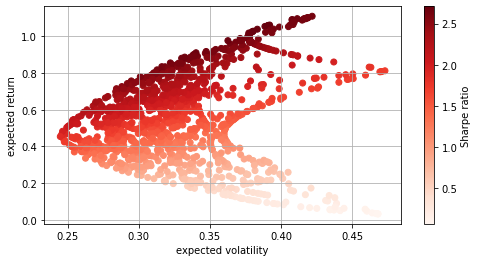

In [39]:
#下面画图
plt.figure(figsize=(8, 4))
plt.scatter(port_variance, port_returns, c=port_returns/port_variance, cmap='Reds',marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.savefig('均值方差.png')
plt.show()

In [40]:
noa = returns_clean.shape[1]#股票数量
def statistics(weights):#计算收益率，方差和夏普比
    weights = np.array(weights)
    port_returns = np.sum(returns_clean.mean()*252*weights)
    port_variance = np.sqrt(np.dot(weights.T, np.dot(returns_clean.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

def min_sharpe(weights):#最小化夏普
    return-statistics(weights)[2]
#设置约束条件：权重之和等于1
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
#设置搜索范围
bnds = tuple((0,1) for x in range(noa))
#最小化最小化夏普等于最大化夏普
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)

In [41]:
def min_variance(weights):#最小化方差
    return statistics(weights)[1]**2
# 最小化方差
optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
print(optv)

     fun: 0.05984637860778895
     jac: array([0.11977888, 0.11959526, 0.11939819, 0.11972115, 0.14675132])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.08100849, 0.00904686, 0.09885413, 0.81109052, 0.        ])


In [42]:
# cons=({'type': 'eq','fun':lambda x:np.sum(x) - 1},{'type': 'eq','fun': lambda x: statistics(x)[0] - tret})
bnds=tuple((0,1)for x in range(noa))
def min_port(weights):#求有效前沿，最小化标准差
    return statistics(weights)[1]
trets=np.linspace(port_returns.min(),port_returns.max(),200)#收益率
tvols=[]

for tret in tqdm(trets):#给定收益率，最小标准差
    #约束条件：收益率给定，权重和等于1
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    #最小化
    res = sco.minimize(min_port, noa * [1. / noa, ], method='SLSQP', bounds=bnds, constraints=cons)
    #res['fun']的值就是最小的标准差值
    tvols.append(res['fun'])
tvols = np.array(tvols)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 23.62it/s]


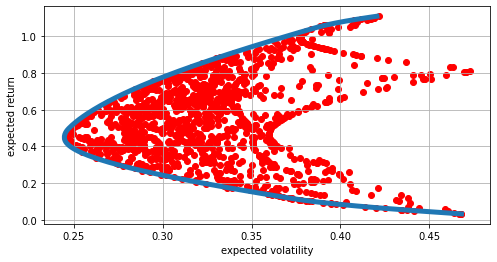

In [43]:
plt.figure(figsize=(8,4))
plt.scatter(port_variance,port_returns,c='r')
plt.plot(tvols,trets,linewidth = 5)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.savefig('马科维茨有效前沿.png')
plt.show()